In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import dotenv
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from incense import ExperimentLoader
import seaborn as sns
from dashboard.utils.mechanics import isotropic_elasticity_matrix, calculate_elastic_properties
import pandas as pd

plt.rcParams['figure.dpi'] = 300


dotenv.load_dotenv()

MONGO_URI = os.getenv('LOCAL_MONGO_URI')
MONGO_DB_NAME = os.getenv('LOCAL_MONGO_DB_NAME')
MONGO_EXP_NAME = os.getenv('LOCAL_MONGO_EXP_NAME')

DEFAULT_FILTER_TAGS = ['BAD', 'DUPE']
DB_QUERY = {"$and": [
    {'experiment.name': MONGO_EXP_NAME},
    {'status': 'COMPLETED'},
    {'omniboard.tags': {'$nin': DEFAULT_FILTER_TAGS}},
    {'config.nu': {'$eq': 0.1}},
    {'config.single_sim': {'$eq': True}}
]}


def last(x): return x.iloc[-1]


loader = ExperimentLoader(
    mongo_uri=MONGO_URI,
    db_name=MONGO_DB_NAME
)

exps = loader.find(DB_QUERY)

In [87]:
metrics = ('E1', 'E2', 'G12', 'nu12', 'nu21', 'eta121', 'eta122',
           'Normed_Eigenvalue_0', 'Normed_Eigenvalue_1')
metric_dicts = [{f'metrics.{m}': last} for m in metrics]
configs = ('basis_v', 'extremal_mode', 'init_run_idx')
config_list = [f'config.{c}' for c in configs]

df = exps.project(on=[*metric_dicts,
                      *config_list
                      ])

df.rename(columns={c: c.removesuffix("_last") for c in df.columns},
          inplace=True)

# df[df['basis_v'] == 'HSA'] = "HS"
df['basis_v'] = df['basis_v'].replace('HSA', 'HS')

df.sort_values(axis=0, by='basis_v', inplace=True)


# Add homogenous datapoints manually
C_high = isotropic_elasticity_matrix(1., 0.15, output_style='mandel')
C_low = isotropic_elasticity_matrix(1/40, 0.05, output_style='mandel')
mat_prop_high = calculate_elastic_properties(C_high, input_style='mandel')
mat_prop_low = calculate_elastic_properties(C_low, input_style='mandel')
eigv_high = np.linalg.eigvalsh(C_high)
eigv_low = np.linalg.eigvalsh(C_low)
# homo_high = pd.DataFrame({})
hom_samples = pd.DataFrame({
    'E1': [mat_prop_high[0], mat_prop_low[0]],
    'E2': [mat_prop_high[1], mat_prop_low[1]],
    'G12': [mat_prop_high[2], mat_prop_low[2]],
    'nu12': [mat_prop_high[3], mat_prop_low[3]],
    'eta121': [mat_prop_high[4], mat_prop_low[4]],
    'nu21': [mat_prop_high[5], mat_prop_low[5]],
    'eta122': [mat_prop_high[6], mat_prop_low[6]],
    'Normed_Eigenvalue_0': [eigv_high[0]/eigv_high[2], eigv_low[0]/eigv_low[2]],
    'Normed_Eigenvalue_1': [eigv_high[1]/eigv_high[2], eigv_low[1]/eigv_low[2]],
    'basis_v': ['HOM', 'HOM'],
    'extremal_mode': [0., 0.]
})

df = pd.concat([df, hom_samples])

df.head()

,E1,E2,G12,nu12,nu21,eta121,eta122,Normed_Eigenvalue_0,Normed_Eigenvalue_1,basis_v,extremal_mode,init_run_idx
681,0.387091,0.391772,0.191437,0.136264,0.137912,-0.011740,0.016405,0.754408,0.853190,BULK,1.0,506.0
718,0.194987,0.194963,0.088003,0.308326,0.308289,0.001362,0.001468,0.528678,0.624373,BULK,2.0,539.0
812,0.247059,0.245331,0.088459,0.246188,0.244467,-0.019670,0.018445,0.538692,0.610549,BULK,2.0,647.0
799,0.218025,0.217008,0.098603,0.301266,0.299861,-0.001545,-0.000048,0.537777,0.634119,BULK,2.0,633.0
798,0.225943,0.225137,0.130224,0.206514,0.205777,-0.020524,-0.020919,0.642517,0.875837,BULK,1.0,632.0


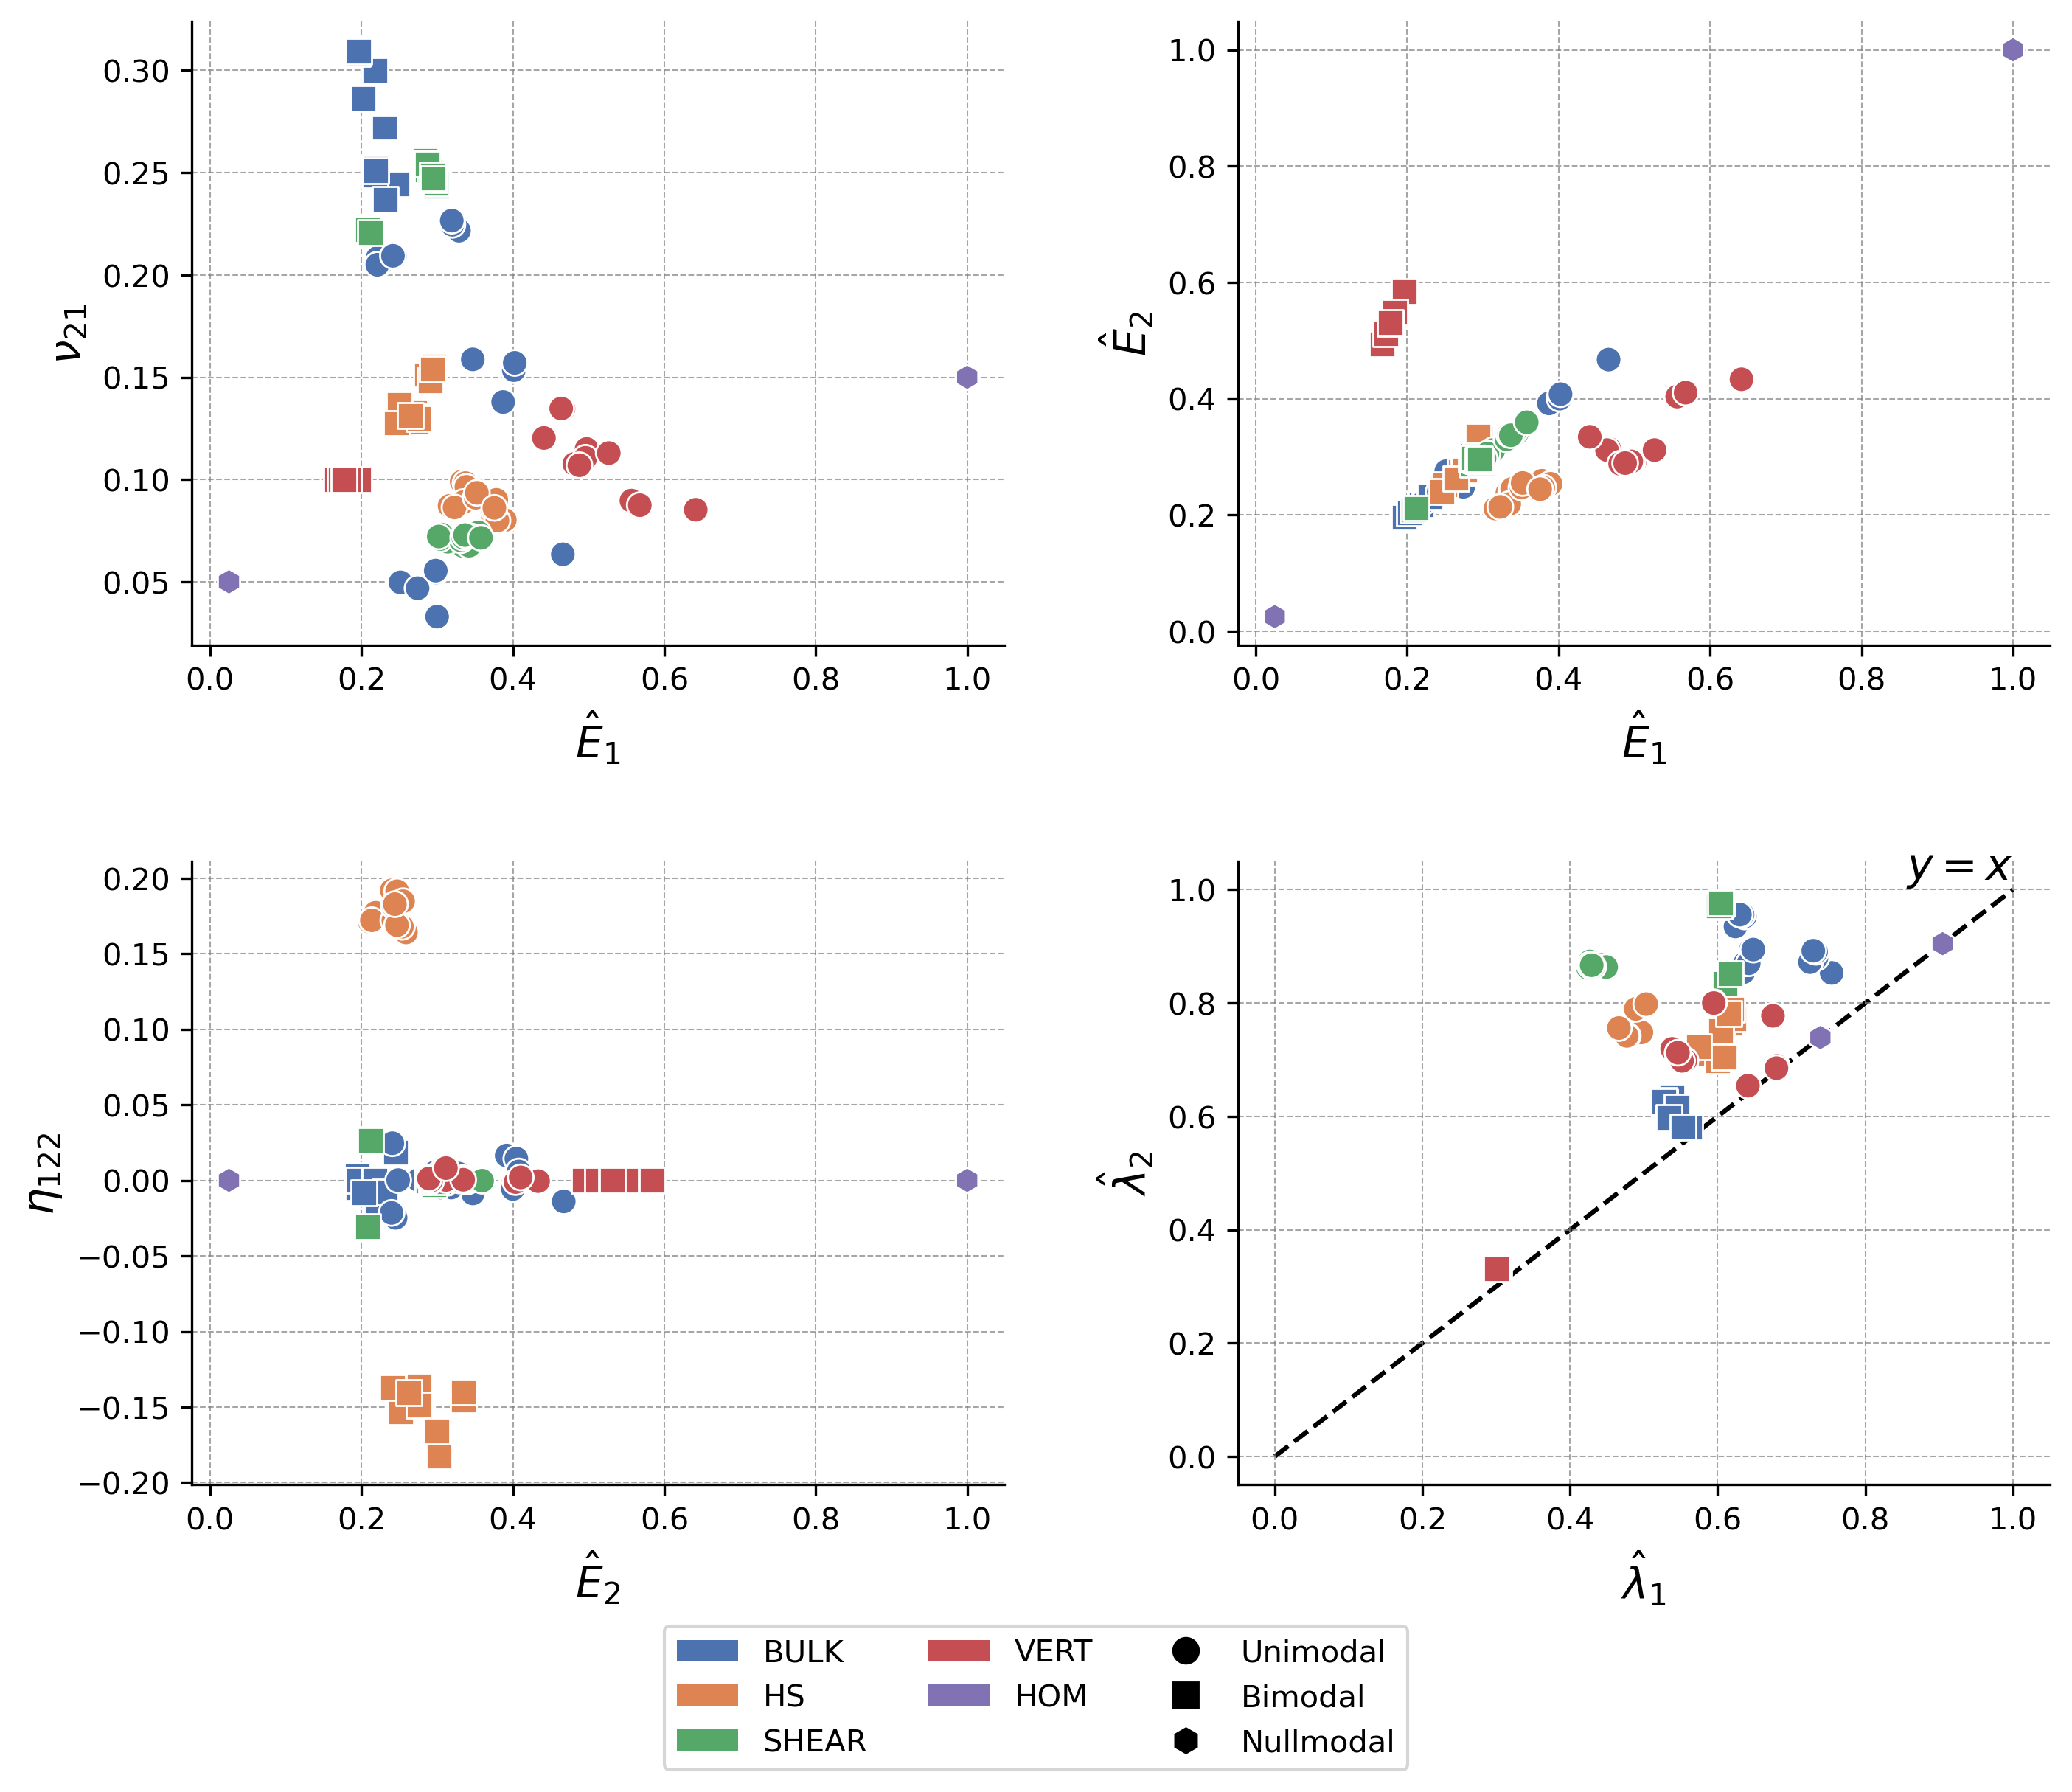

In [ ]:
FONTSIZE = 14

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# the same kwargs used for all plots
kwargs = dict(data=df,
              hue='basis_v',
              style='extremal_mode',
              markers={1: 'o', 2: 's', 0: 'h', },
              s=70,
              legend=False,
              palette='deep',
              )
# pairs of x and y keys into the dataframe
xys = (
    ('E1', 'nu21'),
    ('E1', 'E2'),
    ('E2', 'eta122'),
    ('Normed_Eigenvalue_0', 'Normed_Eigenvalue_1')
)
# actual text we want as axes labels
labs = (
    (r'$\hat{E}_1$', r'$\nu_{21}$'),
    (r'$\hat{E}_1$', r'$\hat{E}_2$'),
    (r'$\hat{E}_2$', r'$\eta_{122}$'),
    (r'$\hat{\lambda}_1$', r'$\hat{\lambda}_2$')
)

for ax, xy, lab in zip(axs.flatten(), xys, labs):
    sns.scatterplot(x=xy[0],
                    y=xy[1],
                    ax=ax,
                    **kwargs)
    ax.set_xlabel(lab[0], fontsize=FONTSIZE)
    ax.set_ylabel(lab[1], fontsize=FONTSIZE)
    [ax.spines[s].set_visible(False) for s in ('top', 'right')]
    plt.tight_layout(pad=3.0)
    ax.set_axisbelow(True)
    ax.grid(True, which='both', linestyle='--',
            linewidth=0.5, color='grey', alpha=0.7)

# y=x for eigenvalue plot
axs[1][1].plot([0, 1], [0, 1], color='k', linestyle='--', zorder=0)
axs[1][1].text(1, 1, r'$y=x$', fontsize=FONTSIZE,
               verticalalignment='bottom', horizontalalignment='right')

color_legend = [Patch(facecolor=c, label=l)
                for l, c in
                zip(df['basis_v'].unique(),
                    sns.color_palette(kwargs['palette'])[:5])]
marker_legend = [Line2D([0], [0],
                        marker=m,
                        color='w',
                        markerfacecolor='k',
                        markersize=10,
                        linestyle='None',
                        label=l)
                 for m, l in
                 zip(kwargs['markers'].values(),
                     ['Unimodal', 'Bimodal', 'Nullmodal'])]
# dummy legend adds a blank spot to the legend so all the markers are in their own column
dummy_legend = [Line2D([], [], color='none', label='')]

fig.legend(handles=color_legend + dummy_legend + marker_legend,
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 0.05),
           fontsize=10)

fig.savefig('images/figure.svg', format='svg')